In [4]:
import re
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

FF_CAL_WEEK_URL = "https://www.forexfactory.com/calendar?week={week_slug}"
JSON_EXPORT_RE = re.compile(r"https://nfs\.faireconomy\.media/ff_calendar_thisweek\.json\?version=[a-f0-9]+")

def sunday_of_week(d: datetime) -> datetime:
    """
    ForexFactory weeks are shown Sun->Sat.
    Return the Sunday date for the week that contains datetime d.
    """
    # Python weekday: Mon=0 ... Sun=6
    days_since_sunday = (d.weekday() + 1) % 7
    sunday = (d - timedelta(days=days_since_sunday)).replace(hour=0, minute=0, second=0, microsecond=0)
    return sunday

def week_slug_from_date(d: datetime) -> str:
    """
    ForexFactory week slug format seen in URLs: e.g. mar1.2026, feb22.2026
    """
    sun = sunday_of_week(d)
    mon = sun.strftime("%b").lower()   # jan, feb, mar...
    return f"{mon}{sun.day}.{sun.year}"

def get_week_json_url(week_slug: str, timeout=15) -> str:
    """
    Fetch the FF calendar HTML for a week and extract the JSON Weekly Export URL.
    """
    url = FF_CAL_WEEK_URL.format(week_slug=week_slug)
    r = requests.get(url, timeout=timeout, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()

    m = JSON_EXPORT_RE.search(r.text)
    if not m:
        raise RuntimeError(f"Could not find JSON export link on page: {url}")
    return m.group(0)

def fetch_week_events(week_slug: str) -> list[dict]:
    """
    Download the JSON export for a specific FF week slug.
    """
    json_url = get_week_json_url(week_slug)
    r = requests.get(json_url, timeout=15, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    return r.json()

def build_news_matrix(days_ahead: int = 30, out_csv: str = "High_Impact_News.csv"):
    print(f"Fetching High-Impact news for {days_ahead} days ahead...")

    # Use UTC "now" for consistent horizon
    now_utc = datetime.now(timezone.utc)
    end_utc = now_utc + timedelta(days=days_ahead)

    # Build list of week slugs covering [now, end]
    week_slugs = []
    cursor = now_utc
    while cursor <= end_utc:
        slug = week_slug_from_date(cursor)
        if slug not in week_slugs:
            week_slugs.append(slug)
        cursor += timedelta(days=7)

    print("Weeks to fetch:", ", ".join(week_slugs))

    all_events = []
    for slug in week_slugs:
        try:
            events = fetch_week_events(slug)
            all_events.extend(events)
            print(f"  ✓ {slug}: {len(events)} events")
        except Exception as e:
            print(f"  ✗ {slug}: {e}")

    if not all_events:
        print("No events fetched.")
        return

    df = pd.DataFrame(all_events)

    # ForexFactory JSON typically uses:
    # title, country (currency), date (ISO with TZ offset), impact, forecast, previous ...
    needed_cols = {"title", "country", "date", "impact"}
    if not needed_cols.issubset(df.columns):
        print("Unexpected JSON schema. Columns found:", df.columns.tolist())
        return

    # Keep only High impact
    df = df[df["impact"] == "High"].copy()

    # Drop missing/All Day (date may be empty for some)
    df = df[df["date"].notna() & (df["date"].astype(str).str.len() > 0)].copy()

    # Parse to UTC
    df["Time_UTC"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
    df = df[df["Time_UTC"].notna()].copy()

    # Horizon filter
    df = df[(df["Time_UTC"] >= now_utc) & (df["Time_UTC"] <= end_utc)].copy()

    # Output format
    out = pd.DataFrame({
        "Time_UTC": df["Time_UTC"].dt.strftime("%Y-%m-%d %H:%M:%S"),
        "Currency": df["country"],
        "Event": df["title"],
    })

    # De-dup & sort
    out = out.drop_duplicates(subset=["Time_UTC", "Currency", "Event"])
    out = out.sort_values("Time_UTC").reset_index(drop=True)

    out.to_csv(out_csv, index=False)
    print("-" * 60)
    print(f"SUCCESS! Saved {len(out)} high-impact events to {out_csv}")
    print(out.head(10))
    print("-" * 60)

if __name__ == "__main__":
    build_news_matrix(days_ahead=30)

Fetching High-Impact news for 30 days ahead...
Weeks to fetch: feb22.2026, mar1.2026, mar8.2026, mar15.2026, mar22.2026
  ✗ feb22.2026: 403 Client Error: Forbidden for url: https://www.forexfactory.com/calendar?week=feb22.2026
  ✗ mar1.2026: 403 Client Error: Forbidden for url: https://www.forexfactory.com/calendar?week=mar1.2026
  ✗ mar8.2026: 403 Client Error: Forbidden for url: https://www.forexfactory.com/calendar?week=mar8.2026
  ✗ mar15.2026: 403 Client Error: Forbidden for url: https://www.forexfactory.com/calendar?week=mar15.2026
  ✗ mar22.2026: 403 Client Error: Forbidden for url: https://www.forexfactory.com/calendar?week=mar22.2026
No events fetched.


In [5]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import pytz
from datetime import datetime
import pandas_ta as ta

# --- Configuration ---
SYMBOLS = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCHF"]
DXY_SYMBOL = "DXY" # Change this if your broker uses "USDX" or "DX"
TIMEFRAME_M15 = mt5.TIMEFRAME_M15
TIMEFRAME_H4 = mt5.TIMEFRAME_H4
EMA_PERIOD = 50
SL_PIPS = 15.0
RR_RATIO = 2.0
TIMEOUT_BARS = 48 

def fetch_data(symbol, timeframe, utc_from, utc_to):
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    if rates is None or len(rates) == 0: return None
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df

def process_symbol(symbol_name, dxy_df, utc_from, utc_to):
    print(f"\n>>> Processing V4 Engine for {symbol_name}...")
    
    # 1. Fetch Auto-Detected Symbol
    symbols_found = mt5.symbols_get(f"*{symbol_name}*")
    if not symbols_found: return None
    actual_symbol = symbols_found[0].name
    
    # Fetch Base M15 Data
    df_m15 = fetch_data(actual_symbol, TIMEFRAME_M15, utc_from, utc_to)
    if df_m15 is None: return None
    
    # Fetch Context H4 Data
    df_h4 = fetch_data(actual_symbol, TIMEFRAME_H4, utc_from, utc_to)
    if df_h4 is None: return None

    info = mt5.symbol_info(actual_symbol)
    pip_val = info.point * (10.0 if info.digits in [3, 5] else 1.0)

    # 2. H4 Feature Engineering (Macro Trend)
    print("Calculating H4 Context...")
    df_h4['h4_ema_50'] = df_h4['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df_h4['h4_dist_to_ema'] = (df_h4['close'] - df_h4['h4_ema_50']) / pip_val
    df_h4['h4_rsi_14'] = ta.rsi(df_h4['close'], length=14)
    df_h4 = df_h4.dropna(subset=['h4_rsi_14', 'h4_dist_to_ema']).copy()
    
    # We shift H4 by 1 to ensure the M15 candle only sees the LAST CLOSED H4 candle
    df_h4['time_aligned'] = df_h4['time'] + pd.Timedelta(hours=4)
    h4_context = df_h4[['time_aligned', 'h4_dist_to_ema', 'h4_rsi_14']].rename(columns={'time_aligned': 'time'})

    # 3. M15 Feature Engineering (Micro Structure)
    print("Calculating M15 Features...")
    df_m15['ema_50'] = df_m15['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df_m15['dist_to_ema'] = (df_m15['close'] - df_m15['ema_50']) / pip_val
    df_m15['hour_of_day'] = df_m15['time'].dt.hour
    df_m15['atr_14'] = ta.atr(df_m15['high'], df_m15['low'], df_m15['close'], length=14)
    df_m15['rsi_14'] = ta.rsi(df_m15['close'], length=14)
    
    # 4. Asynchronous Merging (No Look-Ahead Bias)
    print("Stitching DXY and H4 Tensors...")
    
    # FIX: Force all time arrays to exact same nanosecond resolution before merging
    df_m15['time'] = pd.to_datetime(df_m15['time']).astype('datetime64[ns]')
    h4_context['time'] = pd.to_datetime(h4_context['time']).astype('datetime64[ns]')
    
    # Merge H4 Context
    df_m15 = pd.merge_asof(
        df_m15.sort_values('time'), 
        h4_context.sort_values('time'), 
        on='time', 
        direction='backward'
    )
    
    

    # Merge DXY Context
    if dxy_df is not None:
        dxy_df['time'] = pd.to_datetime(dxy_df['time']).astype('datetime64[ns]')
        dxy_subset = dxy_df[['time', 'dxy_rsi', 'dxy_ema_dist']]
        df_m15 = pd.merge_asof(
            df_m15, 
            dxy_subset.sort_values('time'), 
            on='time', 
            direction='backward'
        )
    else:
        # Fallback if broker lacks DXY
        df_m15['dxy_rsi'] = 50.0 
        df_m15['dxy_ema_dist'] = 0.0

    df_m15.dropna(inplace=True)

    # 5. FVG Detection Logic
    df_m15['prev_high'] = df_m15['high'].shift(2)
    df_m15['prev_low'] = df_m15['low'].shift(2)
    
    df_m15['bull_gap'] = df_m15['low'] - df_m15['prev_high']
    df_m15['is_bull_fvg'] = (df_m15['bull_gap'] > 0) & (df_m15['close'].shift(1) > df_m15['close'].shift(2))
    df_m15['bull_fvg_size'] = np.where(df_m15['is_bull_fvg'], df_m15['bull_gap'] / pip_val, 0.0)
    
    df_m15['bear_gap'] = df_m15['prev_low'] - df_m15['high']
    df_m15['is_bear_fvg'] = (df_m15['bear_gap'] > 0) & (df_m15['close'].shift(1) < df_m15['close'].shift(2))
    df_m15['bear_fvg_size'] = np.where(df_m15['is_bear_fvg'], df_m15['bear_gap'] / pip_val, 0.0)
    
    df_m15['bull_fvg_atr_ratio'] = np.where(df_m15['is_bull_fvg'], df_m15['bull_gap'] / df_m15['atr_14'], 0.0)
    df_m15['bear_fvg_atr_ratio'] = np.where(df_m15['is_bear_fvg'], df_m15['bear_gap'] / df_m15['atr_14'], 0.0)
    
    fvg_df = df_m15[(df_m15['is_bull_fvg']) | (df_m15['is_bear_fvg'])].copy()
    
    # 6. Labeling
    print(f"Labeling {len(fvg_df)} setups for {actual_symbol}...")
    y_labels = []
    sl_points = SL_PIPS * pip_val
    tp_points = sl_points * RR_RATIO
    times = df_m15['time'].values
    highs = df_m15['high'].values
    lows = df_m15['low'].values
    
    for _, row in fvg_df.iterrows():
        future_idx = np.where(times > row['time'])[0]
        if len(future_idx) == 0: y_labels.append(0); continue
            
        max_search = min(len(future_idx), TIMEOUT_BARS)
        f_highs = highs[future_idx[:max_search]]
        f_lows = lows[future_idx[:max_search]]
        outcome = 0 
        
        if row['is_bull_fvg']:
            sl, tp = row['low'] - sl_points, row['low'] + tp_points
            for h, l in zip(f_highs, f_lows):
                if l <= sl: outcome = 0; break
                if h >= tp: outcome = 1; break
        else: 
            sl, tp = row['high'] + sl_points, row['high'] - tp_points
            for h, l in zip(f_highs, f_lows):
                if h >= sl: outcome = 0; break
                if l <= tp: outcome = 1; break
        y_labels.append(outcome)
        
    fvg_df['target'] = y_labels
    fvg_df['symbol'] = symbol_name 
    
    # The NEW 13-Dimensional Feature Matrix
    return fvg_df[['time', 'symbol', 'tick_volume', 'hour_of_day', 'rsi_14', 'atr_14', 
                   'dist_to_ema', 'bull_fvg_size', 'bear_fvg_size', 
                   'bull_fvg_atr_ratio', 'bear_fvg_atr_ratio', 
                   'h4_rsi_14', 'h4_dist_to_ema', 'dxy_rsi', 'dxy_ema_dist', 'target']]

def run_v4_batch_extraction():
    if not mt5.initialize(): return

    timezone = pytz.timezone("Etc/UTC")
    utc_from = datetime(2024, 5, 1, tzinfo=timezone)
    utc_to = datetime(2025, 5, 1, tzinfo=timezone)

    # Prepare Global DXY Reference Table
    print("\nAttempting to load US Dollar Index (DXY)...")
    dxy_found = mt5.symbols_get(f"*{DXY_SYMBOL}*")
    dxy_df = None
    if dxy_found:
        dxy_name = dxy_found[0].name
        dxy_raw = fetch_data(dxy_name, TIMEFRAME_M15, utc_from, utc_to)
        if dxy_raw is not None:
            dxy_raw['dxy_ema_50'] = dxy_raw['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
            dxy_raw['dxy_ema_dist'] = dxy_raw['close'] - dxy_raw['dxy_ema_50']
            dxy_raw['dxy_rsi'] = ta.rsi(dxy_raw['close'], length=14)
            dxy_df = dxy_raw[['time', 'dxy_rsi', 'dxy_ema_dist']].dropna()
            print("SUCCESS: US Dollar Index tracking enabled.")
    
    if dxy_df is None:
        print("WARNING: DXY symbol not found on your broker. Defaulting to 0 for DXY features.")

    all_data = []
    for sym in SYMBOLS:
        res = process_symbol(sym, dxy_df, utc_from, utc_to)
        if res is not None:
            all_data.append(res)
            res.to_csv(f"{sym}_V4_Matrix.csv", index=False)
    
    mt5.shutdown()
    
    if all_data:
        master_df = pd.concat(all_data, ignore_index=True)
        master_df.to_csv("GLOBAL_FVG_V4_MASTER_MATRIX.csv", index=False)
        print("\n" + "="*50)
        print(f"SUCCESS! 13-Dimensional V4 Dataset Created.")
        print(f"Total Symbols: {len(SYMBOLS)}")
        print(f"Total Global Setups: {len(master_df)}")
        print(f"Master file saved as: GLOBAL_FVG_V4_MASTER_MATRIX.csv")
        print("="*50)

if __name__ == "__main__":
    run_v4_batch_extraction()


Attempting to load US Dollar Index (DXY)...
SUCCESS: US Dollar Index tracking enabled.

>>> Processing V4 Engine for EURUSD...
Calculating H4 Context...
Calculating M15 Features...
Stitching DXY and H4 Tensors...
Labeling 5071 setups for EURUSD...

>>> Processing V4 Engine for GBPUSD...
Calculating H4 Context...
Calculating M15 Features...
Stitching DXY and H4 Tensors...
Labeling 5015 setups for GBPUSD...

>>> Processing V4 Engine for USDJPY...
Calculating H4 Context...
Calculating M15 Features...
Stitching DXY and H4 Tensors...
Labeling 5403 setups for USDJPY...

>>> Processing V4 Engine for AUDUSD...
Calculating H4 Context...
Calculating M15 Features...
Stitching DXY and H4 Tensors...
Labeling 5060 setups for AUDUSD...

>>> Processing V4 Engine for USDCHF...
Calculating H4 Context...
Calculating M15 Features...
Stitching DXY and H4 Tensors...
Labeling 5009 setups for USDCHF...

SUCCESS! 13-Dimensional V4 Dataset Created.
Total Symbols: 5
Total Global Setups: 25558
Master file saved 

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, brier_score_loss

# ONNX Conversion Imports
import onnx
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost

# --- REGISTER CONVERTER ---
update_registered_converter(
    xgb.XGBClassifier, "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "renamed"]}
)

# ---- CONFIG ----
TIME_COL = "time"         # <-- change if your dataset uses a different name
MIN_ROWS = 300
TEST_FRAC = 0.20          # last 20% = test
CAL_FRAC = 0.10           # preceding 10% = calibration
GAP_BARS = 0              # optional embargo gap between splits (set e.g. 5 or 10)

FEATURES = [
    "tick_volume", "hour_of_day", "rsi_14", "atr_14",
    "dist_to_ema", "bull_fvg_size", "bear_fvg_size",
    "bull_fvg_atr_ratio", "bear_fvg_atr_ratio",
    "h4_rsi_14", "h4_dist_to_ema", "dxy_rsi", "dxy_ema_dist"
]
TARGET = "target"


def ensure_sorted(sym_df: pd.DataFrame) -> pd.DataFrame:
    """Sort by time (strict) to avoid leakage."""
    if TIME_COL in sym_df.columns:
        out = sym_df.copy()
        out[TIME_COL] = pd.to_datetime(out[TIME_COL], errors="coerce", utc=True)
        out = out.dropna(subset=[TIME_COL])
        out = out.sort_values(TIME_COL).reset_index(drop=True)
        return out

    # Fallback: stable order (NOT ideal). Strongly recommend adding a time column.
    return sym_df.reset_index(drop=True)


def make_splits(n: int, test_frac: float, cal_frac: float, gap: int):
    """
    Time-safe split:
      [ train .... ][ gap ][ calibrate ][ gap ][ test ]
    """
    if test_frac <= 0 or cal_frac <= 0 or (test_frac + cal_frac) >= 0.8:
        raise ValueError("Bad split fractions. Keep test+cal reasonably small (e.g., 0.30 total).")

    test_size = int(round(n * test_frac))
    cal_size = int(round(n * cal_frac))
    train_end = n - (cal_size + test_size)

    # apply gaps
    cal_start = train_end + gap
    cal_end = n - test_size
    test_start = cal_end + gap

    # adjust if gaps push beyond bounds
    cal_start = min(cal_start, n)
    cal_end = min(cal_end, n)
    test_start = min(test_start, n)

    train_idx = np.arange(0, max(train_end, 0))
    cal_idx = np.arange(cal_start, max(cal_end, cal_start))
    test_idx = np.arange(test_start, n)

    return train_idx, cal_idx, test_idx


def train_v4_specialist_models():
    print("Loading V4 13-Dimensional Master Dataset...")
    try:
        df = pd.read_csv("GLOBAL_FVG_V4_MASTER_MATRIX.csv").dropna()
    except FileNotFoundError:
        print("Error: GLOBAL_FVG_V4_MASTER_MATRIX.csv not found.")
        return

    if "symbol" not in df.columns:
        print("ERROR: CSV must contain a 'symbol' column.")
        return

    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        print("ERROR: Missing required columns:", missing)
        return

    symbols = df["symbol"].unique()
    print(f"Found {len(symbols)} symbols. Training V4 Specialists...")

    for sym in symbols:
        print("\n" + "=" * 45)
        print(f" TRAINING V4 SPECIALIST: {sym} ")
        print("=" * 45)

        sym_df = df[df["symbol"] == sym].copy()
        sym_df = ensure_sorted(sym_df)

        if len(sym_df) < MIN_ROWS:
            print(f"Skipping {sym}: Not enough data ({len(sym_df)} rows).")
            continue

        X = sym_df[FEATURES].to_numpy(dtype=np.float32)
        y = sym_df[TARGET].to_numpy(dtype=np.int32)

        # --- time-safe splits
        train_idx, cal_idx, test_idx = make_splits(len(sym_df), TEST_FRAC, CAL_FRAC, GAP_BARS)

        if len(train_idx) < 100 or len(cal_idx) < 50 or len(test_idx) < 50:
            print(f"Skipping {sym}: split too small (train={len(train_idx)}, cal={len(cal_idx)}, test={len(test_idx)}).")
            continue

        X_train, y_train = X[train_idx], y[train_idx]
        X_cal, y_cal     = X[cal_idx], y[cal_idx]
        X_test, y_test   = X[test_idx], y[test_idx]

        pos_cases = int((y_train == 1).sum())
        neg_cases = int((y_train == 0).sum())
        imbalance = (neg_cases / pos_cases) if pos_cases > 0 else 1.0

        base_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=imbalance,
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )

        # ---- Fit base model on TRAIN only
        base_model.fit(X_train, y_train)

        # ---- Calibrate on a FUTURE slice (calibration window), time-safe
        # Use cv="prefit" so it does NOT cross-validate/shuffle.
        calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv="prefit")
        calibrated_model.fit(X_cal, y_cal)

        # ---- Evaluate on last slice (TEST)
        preds = calibrated_model.predict(X_test)
        proba = calibrated_model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)

        # Better trading-relevant diagnostics
        auc = roc_auc_score(y_test, proba) if len(np.unique(y_test)) > 1 else float("nan")
        ll = log_loss(y_test, proba, labels=[0, 1])
        brier = brier_score_loss(y_test, proba)

        print(f"Time OOS Accuracy for {sym}: {acc:.2%}")
        print(f"Time OOS AUC: {auc:.3f} | LogLoss: {ll:.4f} | Brier: {brier:.4f}")

        # ---- Export ONNX (13-dim input)
        initial_type = [("float_input", FloatTensorType([None, 13]))]
        onx = convert_sklearn(
            calibrated_model,
            initial_types=initial_type,
            target_opset={"": 12, "ai.onnx.ml": 3},
            options={type(calibrated_model): {"zipmap": False}}
        )

        filename = f"fvg_model_{sym}_v4.onnx"
        with open(filename, "wb") as f:
            f.write(onx.SerializeToString())

        print(f"SUCCESS: Saved {filename}")


if __name__ == "__main__":
    train_v4_specialist_models()

Loading V4 13-Dimensional Master Dataset...
Found 5 symbols. Training V4 Specialists...

 TRAINING V4 SPECIALIST: EURUSD 
Time OOS Accuracy for EURUSD: 59.76%
Time OOS AUC: 0.597 | LogLoss: 0.6641 | Brier: 0.2359
SUCCESS: Saved fvg_model_EURUSD_v4.onnx

 TRAINING V4 SPECIALIST: GBPUSD 
Time OOS Accuracy for GBPUSD: 59.92%
Time OOS AUC: 0.576 | LogLoss: 0.6675 | Brier: 0.2375
SUCCESS: Saved fvg_model_GBPUSD_v4.onnx

 TRAINING V4 SPECIALIST: USDJPY 
Time OOS Accuracy for USDJPY: 55.50%
Time OOS AUC: 0.572 | LogLoss: 0.6868 | Brier: 0.2466
SUCCESS: Saved fvg_model_USDJPY_v4.onnx

 TRAINING V4 SPECIALIST: AUDUSD 
Time OOS Accuracy for AUDUSD: 66.60%
Time OOS AUC: 0.638 | LogLoss: 0.6294 | Brier: 0.2174
SUCCESS: Saved fvg_model_AUDUSD_v4.onnx

 TRAINING V4 SPECIALIST: USDCHF 
Time OOS Accuracy for USDCHF: 62.38%
Time OOS AUC: 0.656 | LogLoss: 0.6489 | Brier: 0.2287
SUCCESS: Saved fvg_model_USDCHF_v4.onnx


Loading Global Master Dataset...
Training Reference Global Model (time-safe)...

Sweeping thresholds for all symbols (TEST slice only)...

      OPTIMAL PORTFOLIO CONFIGURATION      
SYMBOL: AUDUSD  | BEST THRESHOLD: 0.50 | PF: 2.58 | Trades: 174 | WR: 56.3%
SYMBOL: EURUSD  | BEST THRESHOLD: 0.65 | PF: 2.74 | Trades: 45 | WR: 57.8%
SYMBOL: GBPUSD  | BEST THRESHOLD: 0.60 | PF: 2.41 | Trades: 150 | WR: 54.7%
SYMBOL: USDCHF  | BEST THRESHOLD: 0.65 | PF: 3.10 | Trades: 51 | WR: 60.8%
SYMBOL: USDJPY  | BEST THRESHOLD: 0.70 | PF: 4.46 | Trades: 42 | WR: 69.0%
Saved metrics to: Portfolio_Optimization_Metrics.csv
Saved chart to: Portfolio_Optimization_Results.png


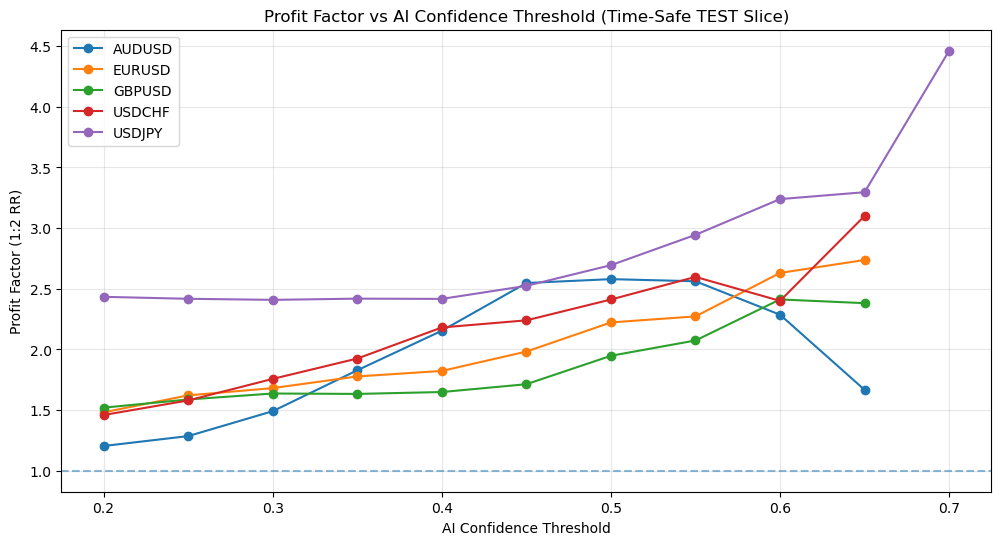

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
TIME_COL = "time"          # <-- change if your column is 'timestamp'/'datetime' etc.
TRAIN_FRAC = 0.70          # earliest 70%
CAL_FRAC = 0.10            # next 10% for calibration
TEST_FRAC = 0.20           # last 20% for threshold sweep

GAP_ROWS = 0               # optional embargo gap rows between splits (set 5-50 if you want)
MIN_TRADES = 20            # ignore thresholds with fewer trades
MIN_POS_IN_TRAIN = 50      # skip if not enough positives in training (stability)

THRESHOLDS = np.arange(0.20, 0.71, 0.05)

FEATURES = [
    "tick_volume", "hour_of_day", "rsi_14", "atr_14",
    "dist_to_ema", "bull_fvg_size", "bear_fvg_size",
    "bull_fvg_atr_ratio", "bear_fvg_atr_ratio"
]
TARGET = "target"
SYMBOL_COL = "symbol"


def ensure_time_sorted(df: pd.DataFrame) -> pd.DataFrame:
    if TIME_COL not in df.columns:
        # Fallback: stable order. Not ideal. Strongly recommend adding TIME_COL to dataset.
        return df.reset_index(drop=True)

    out = df.copy()
    out[TIME_COL] = pd.to_datetime(out[TIME_COL], errors="coerce", utc=True)
    out = out.dropna(subset=[TIME_COL])
    out = out.sort_values(TIME_COL).reset_index(drop=True)
    return out


def time_splits(n: int, train_frac: float, cal_frac: float, test_frac: float, gap: int):
    # sanity
    if abs((train_frac + cal_frac + test_frac) - 1.0) > 1e-6:
        raise ValueError("TRAIN_FRAC + CAL_FRAC + TEST_FRAC must sum to 1.0")

    n_train = int(round(n * train_frac))
    n_cal = int(round(n * cal_frac))
    # test is whatever remains
    n_test = n - n_train - n_cal

    train_end = n_train
    cal_start = train_end + gap
    cal_end = train_end + n_cal
    test_start = cal_end + gap

    # clamp
    cal_start = min(max(cal_start, 0), n)
    cal_end = min(max(cal_end, cal_start), n)
    test_start = min(max(test_start, cal_end), n)

    train_idx = np.arange(0, train_end)
    cal_idx = np.arange(cal_start, cal_end)
    test_idx = np.arange(test_start, n)

    return train_idx, cal_idx, test_idx


def build_model(scale_pos_weight: float) -> xgb.XGBClassifier:
    return xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    )


def run_portfolio_threshold_optimization():
    print("Loading Global Master Dataset...")
    try:
        df = pd.read_csv("GLOBAL_FVG_V4_MASTER_MATRIX.csv").dropna()
    except FileNotFoundError:
        print("Error: GLOBAL_FVG_V4_MASTER_MATRIX.csv not found.")
        return

    # basic checks
    missing = [c for c in FEATURES + [TARGET, SYMBOL_COL] if c not in df.columns]
    if missing:
        print("ERROR: Missing columns:", missing)
        return

    # sort globally by time if available (important for time split)
    df = ensure_time_sorted(df)

    n = len(df)
    if n < 1000:
        print(f"WARNING: dataset seems small (rows={n}). Results may be noisy.")

    # 1) Time-safe global split: TRAIN -> CAL -> TEST
    train_idx, cal_idx, test_idx = time_splits(n, TRAIN_FRAC, CAL_FRAC, TEST_FRAC, GAP_ROWS)

    train_df = df.iloc[train_idx].copy()
    cal_df = df.iloc[cal_idx].copy()
    test_df = df.iloc[test_idx].copy()

    if len(train_df) == 0 or len(cal_df) == 0 or len(test_df) == 0:
        print("ERROR: one of the splits is empty. Adjust fractions/GAP_ROWS.")
        return

    X_train = train_df[FEATURES].to_numpy(dtype=np.float32)
    y_train = train_df[TARGET].to_numpy(dtype=np.int32)

    X_cal = cal_df[FEATURES].to_numpy(dtype=np.float32)
    y_cal = cal_df[TARGET].to_numpy(dtype=np.int32)

    # imbalance
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    if pos < MIN_POS_IN_TRAIN:
        print(f"ERROR: Too few positives in TRAIN ({pos}). Increase history or change label definition.")
        return
    scale_pos_weight = neg / pos if pos > 0 else 1.0

    print("Training Reference Global Model (time-safe)...")
    base_model = build_model(scale_pos_weight=scale_pos_weight)
    base_model.fit(X_train, y_train)

    # 1b) Calibrate on later slice (NO CV shuffle/leak)
    model = CalibratedClassifierCV(base_model, method="sigmoid", cv="prefit")
    model.fit(X_cal, y_cal)

    # 2) Optimization Loop on TEST only (future)
    symbols = sorted(test_df[SYMBOL_COL].unique().tolist())
    optimization_results = []

    print("\nSweeping thresholds for all symbols (TEST slice only)...")
    for sym in symbols:
        sym_test = test_df[test_df[SYMBOL_COL] == sym]
        if len(sym_test) == 0:
            continue

        X_sym = sym_test[FEATURES].to_numpy(dtype=np.float32)
        y_sym = sym_test[TARGET].to_numpy(dtype=np.int32)

        probs = model.predict_proba(X_sym)[:, 1]

        for t in THRESHOLDS:
            take = probs >= t
            total = int(take.sum())
            if total < MIN_TRADES:
                continue

            wins = int(np.sum(take & (y_sym == 1)))
            losses = int(np.sum(take & (y_sym == 0)))

            # 1:2 RR toy PF
            gross_profit = wins * 2.0
            gross_loss = losses * 1.0
            profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else 5.0
            win_rate = (wins / total) * 100.0

            optimization_results.append({
                "Symbol": sym,
                "Threshold": float(t),
                "Profit_Factor": float(profit_factor),
                "Win_Rate": float(win_rate),
                "Trades": int(total),
                "Wins": int(wins),
                "Losses": int(losses),
            })

    results_df = pd.DataFrame(optimization_results)
    if results_df.empty:
        print("No results. Try lowering MIN_TRADES or widening threshold range.")
        return

    # 3) Find best threshold per symbol with a stability constraint
    print("\n" + "="*50)
    print("      OPTIMAL PORTFOLIO CONFIGURATION      ")
    print("="*50)

    plt.figure(figsize=(12, 6))

    for sym in symbols:
        sym_res = results_df[results_df["Symbol"] == sym].copy()
        if sym_res.empty:
            continue

        # Prefer higher PF, but also prefer more trades if PF ties
        sym_res = sym_res.sort_values(["Profit_Factor", "Trades"], ascending=[False, False])
        best_row = sym_res.iloc[0]

        print(
            f"SYMBOL: {sym:7} | BEST THRESHOLD: {best_row['Threshold']:.2f} "
            f"| PF: {best_row['Profit_Factor']:.2f} | Trades: {int(best_row['Trades'])} "
            f"| WR: {best_row['Win_Rate']:.1f}%"
        )

        # Plot PF vs threshold
        sym_plot = results_df[results_df["Symbol"] == sym].sort_values("Threshold")
        plt.plot(sym_plot["Threshold"], sym_plot["Profit_Factor"], label=sym, marker="o")

    # 4) Finalization
    plt.title("Profit Factor vs AI Confidence Threshold (Time-Safe TEST Slice)")
    plt.xlabel("AI Confidence Threshold")
    plt.ylabel("Profit Factor (1:2 RR)")
    plt.axhline(1.0, linestyle="--", alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig("Portfolio_Optimization_Results.png")

    results_df.to_csv("Portfolio_Optimization_Metrics.csv", index=False)
    print("="*50)
    print("Saved metrics to: Portfolio_Optimization_Metrics.csv")
    print("Saved chart to: Portfolio_Optimization_Results.png")


if __name__ == "__main__":
    run_portfolio_threshold_optimization()

Loading GLOBAL V4 master dataset...
Step 1: Extracting V4 walk-forward trades (time-safe calibration)...
Fold 1: trades so far = 74
Fold 2: trades so far = 1153
Fold 3: trades so far = 2062
Fold 4: trades so far = 3695
Fold 5: trades so far = 6188
Extracted 6188 out-of-sample trades (global).
Step 2: Running 1,000 Monte Carlo simulations...

      V4 GLOBAL MONTE CARLO STRESS TEST REPORT      
Trades sampled (OOS):        6188
Threshold:                  0.4
Risk per trade:             1.00% | RR: 1:2 | Compounding: True
Average Ending Balance:     $55,051,813,513,841,536.00
95% Confidence Interval:    $2,620,939,723,808,655.00 to $238,317,270,090,902,176.00
Worst Case Scenario:        $607,424,918,057,231.62
Median Max Drawdown:        14.20%
Prop Firm Ruin Risk (>10%): 99.80%
Total Ruin Risk (>20%):     3.80%


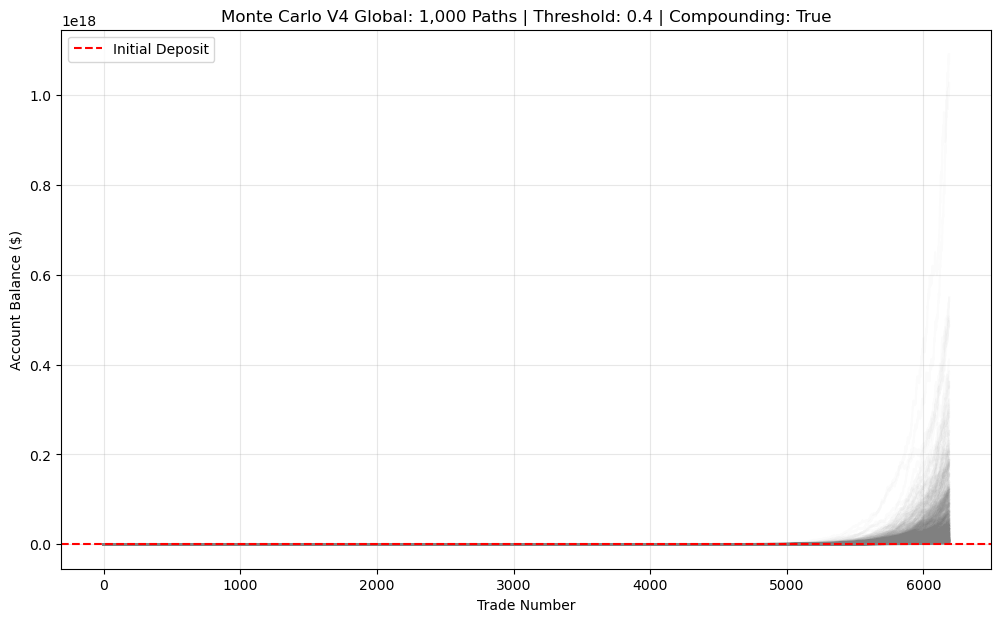

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt


def run_v4_complete_stress_test_global():
    # =========================
    # 1) LOAD GLOBAL V4 DATA
    # =========================
    print("Loading GLOBAL V4 master dataset...")
    try:
        df = pd.read_csv("GLOBAL_FVG_V4_MASTER_MATRIX.csv").dropna()
    except FileNotFoundError:
        print("Error: GLOBAL_FVG_V4_MASTER_MATRIX.csv not found.")
        return

    # Ensure time-safe ordering
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)
        df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
    else:
        # fallback: stable ordering, but strongly recommended to include 'time'
        df = df.reset_index(drop=True)

    # 13-Dimensional features matching V4 MQL5 production
    features = [
        "tick_volume", "hour_of_day", "rsi_14", "atr_14",
        "dist_to_ema", "bull_fvg_size", "bear_fvg_size",
        "bull_fvg_atr_ratio", "bear_fvg_atr_ratio",
        "h4_rsi_14", "h4_dist_to_ema", "dxy_rsi", "dxy_ema_dist"
    ]

    # Basic checks
    missing = [c for c in (features + ["target"]) if c not in df.columns]
    if missing:
        print("ERROR: Missing columns:", missing)
        return

    X = df[features].to_numpy(dtype=np.float32)
    y = df["target"].to_numpy(dtype=np.int32)

    # =========================
    # USER CONTROLS
    # =========================
    # Walk-forward / model
    N_SPLITS = 5
    CAL_FRAC_OF_TRAIN = 0.20   # last 20% of training window used for calibration (time-safe)
    GAP_BARS = 0               # optional embargo rows between train->cal and cal->test

    # Trading model
    CONFIDENCE_THRESHOLD = 0.40
    RR = 2.0
    RISK_PCT = 0.01
    INITIAL_BALANCE = 10000.0

    # Monte Carlo realism upgrades
    NUM_SIMULATIONS = 1000
    COMPOUND_RISK = False      # recommended for stress testing (turn True if you REALLY want)
    BLOCK_SIZE = 30            # block bootstrap to preserve streaks/regimes (20-50 typical)
    COST_R_MULT = 0.10         # costs in "R" units (0.10R ~ mild spread/slippage/fees)

    # Hard risk stops (optional prop-like behavior)
    STOP_AT_DD = 0.20          # stop trading when max drawdown exceeds 20% (set None to disable)
    DAILY_LOSS_LIMIT = None    # not modeled here (needs timestamps). Keep None for now.

    # =========================
    # 2) WALK-FORWARD TRADE EXTRACTION
    # =========================
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    all_trade_results = []   # store win/loss stream (1=win, 0=loss)

    print("Step 1: Extracting V4 walk-forward trades (time-safe calibration)...")

    for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
        n_train = len(train_index)
        cal_size = int(round(n_train * CAL_FRAC_OF_TRAIN))
        if cal_size < 200:
            print(f"Fold {fold}: calibration slice too small ({cal_size}). Skipping fold.")
            continue

        train_core = train_index[: max(n_train - cal_size, 0)]
        cal_idx = train_index[max(n_train - cal_size, 0):]

        # Optional embargo gap (reduces adjacent leakage)
        if GAP_BARS > 0:
            cut = cal_idx[0] - GAP_BARS
            train_core = train_core[train_core <= cut]
            cut2 = test_index[0] - GAP_BARS
            cal_idx = cal_idx[cal_idx <= cut2]

        if len(train_core) < 500 or len(cal_idx) < 200 or len(test_index) < 200:
            print(f"Fold {fold}: split too small. train={len(train_core)} cal={len(cal_idx)} test={len(test_index)}")
            continue

        X_train, y_train = X[train_core], y[train_core]
        X_cal, y_cal     = X[cal_idx], y[cal_idx]
        X_test, y_test   = X[test_index], y[test_index]

        pos = int((y_train == 1).sum())
        neg = int((y_train == 0).sum())
        if pos == 0:
            print(f"Fold {fold}: no positives in training. Skipping fold.")
            continue
        imbalance = neg / pos

        base_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=imbalance,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        )

        # Fit on TRAIN only
        base_model.fit(X_train, y_train)

        # Calibrate on CAL only (cv="prefit" = no shuffled CV leakage)
        calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv="prefit")
        calibrated_model.fit(X_cal, y_cal)

        probs = calibrated_model.predict_proba(X_test)[:, 1]

        # Record win/loss outcomes for Monte Carlo
        for prob, actual in zip(probs, y_test):
            if prob >= CONFIDENCE_THRESHOLD:
                all_trade_results.append(1 if actual == 1 else 0)

        print(f"Fold {fold}: trades so far = {len(all_trade_results)}")

    if len(all_trade_results) == 0:
        print("No trades were triggered. Lower threshold or verify features/labels.")
        return

    all_trade_results = np.array(all_trade_results, dtype=np.int8)
    print(f"Extracted {len(all_trade_results)} out-of-sample trades (global).")

    # =========================
    # 3) MONTE CARLO (BLOCK BOOTSTRAP)
    # =========================
    def block_bootstrap(winloss: np.ndarray, block: int) -> np.ndarray:
        """Bootstrap contiguous blocks to preserve streaks/regime clustering."""
        n = len(winloss)
        out = []
        while len(out) < n:
            start = np.random.randint(0, max(1, n - block))
            out.extend(winloss[start:start + block].tolist())
        return np.array(out[:n], dtype=np.int8)

    def simulate_equity_path(winloss_stream: np.ndarray) -> np.ndarray:
        """Simulate equity path with optional compounding, costs, and DD stop."""
        equity = INITIAL_BALANCE
        peak = INITIAL_BALANCE
        path = [equity]

        fixed_risk = INITIAL_BALANCE * RISK_PCT  # used if COMPOUND_RISK=False

        for wl in winloss_stream:
            # Optional stop if drawdown exceeded
            if STOP_AT_DD is not None:
                dd = (peak - equity) / peak if peak > 0 else 0.0
                if dd >= STOP_AT_DD:
                    break

            risk = (equity * RISK_PCT) if COMPOUND_RISK else fixed_risk
            pnl = (risk * RR) if wl == 1 else (-risk)

            # Transaction costs/slippage modeled as fraction of 1R
            pnl -= (risk * COST_R_MULT)

            equity += pnl
            peak = max(peak, equity)
            path.append(equity)

        return np.array(path, dtype=float)

    print(f"Step 2: Running {NUM_SIMULATIONS:,} Monte Carlo simulations (block bootstrap, costs)...")

    ending_balances = []
    max_drawdowns = []

    plt.figure(figsize=(12, 7))

    for _ in range(NUM_SIMULATIONS):
        sim_winloss = block_bootstrap(all_trade_results, BLOCK_SIZE)
        sim_equity = simulate_equity_path(sim_winloss)

        equity_series = pd.Series(sim_equity)
        rolling_max = equity_series.cummax()
        drawdown = (rolling_max - equity_series) / rolling_max

        ending_balances.append(sim_equity[-1])
        max_drawdowns.append(drawdown.max())

        plt.plot(sim_equity, color="gray", alpha=0.03)

    ending_balances = np.array(ending_balances, dtype=float)
    max_drawdowns = np.array(max_drawdowns, dtype=float)

    # =========================
    # 4) REPORT
    # =========================
    print("\n" + "=" * 55)
    print("      V4 GLOBAL MONTE CARLO STRESS TEST REPORT      ")
    print("=" * 55)
    print(f"Trades sampled (OOS):         {len(all_trade_results)}")
    print(f"Threshold:                   {CONFIDENCE_THRESHOLD}")
    print(f"Risk per trade:              {RISK_PCT*100:.2f}% | RR: 1:{RR:.0f}")
    print(f"Costs:                       {COST_R_MULT:.2f}R per trade")
    print(f"Bootstrap:                   block_size={BLOCK_SIZE}")
    print(f"Compounding:                 {COMPOUND_RISK}")
    print(f"Stop at max drawdown:        {STOP_AT_DD if STOP_AT_DD is not None else 'OFF'}")
    print("-" * 55)
    print(f"Average Ending Balance:      ${np.mean(ending_balances):,.2f}")
    print(f"Median Ending Balance:       ${np.median(ending_balances):,.2f}")
    print(f"95% Confidence Interval:     ${np.percentile(ending_balances, 2.5):,.2f} to ${np.percentile(ending_balances, 97.5):,.2f}")
    print(f"Worst Case Scenario:         ${np.min(ending_balances):,.2f}")
    print(f"Median Max Drawdown:         {np.median(max_drawdowns):.2%}")
    print(f"Prop Firm Ruin Risk (>10%):  {np.mean(max_drawdowns > 0.10):.2%}")
    print(f"Total Ruin Risk (>20%):      {np.mean(max_drawdowns > 0.20):.2%}")
    print("=" * 55)

    plt.axhline(INITIAL_BALANCE, color="red", linestyle="--", label="Initial Deposit")
    plt.title(
        f"Monte Carlo V4 Global: {NUM_SIMULATIONS:,} Paths | "
        f"Thr={CONFIDENCE_THRESHOLD} | Block={BLOCK_SIZE} | Cost={COST_R_MULT:.2f}R | "
        f"Comp={COMPOUND_RISK}"
    )
    plt.ylabel("Account Balance ($)")
    plt.xlabel("Trade Number (simulated)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    run_v4_complete_stress_test_global()